In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.feature_extractors.SummaryStats2D import DY
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats7'

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    full_summ_stats = STATS['x']
    labels = STATS['y']
    ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = {k: v.copy() for p in ['loc', 'geo', 'bio'] \
    for k, v in config_dict['Simulation_Parameters'].get(p + '_param_range', {}).items()}

print(inference_list)

def save_rf_model(model_name, model, feat_ids=None, label_list=None, overwrite=False):
    """Model name format: input_name_xxx-output_name_yyy-zzz (joined by '-')"""
    name_comps = model_name.split('-')
    in_name, out_name = name_comps[:2]
    MODEL_PATH = os.path.join(TRIAL_PATH, 'RandomForestAnalysis')
    PARAM_PATH = os.path.join(MODEL_PATH, model_name + '.joblib')
    IN_LIST_PATH = os.path.join(MODEL_PATH, in_name + '_in.txt')
    OUT_LIST_PATH = os.path.join(MODEL_PATH, out_name + '_out.txt')
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    if not os.path.isfile(IN_LIST_PATH) and feat_ids is not None or overwrite:
        np.savetxt(IN_LIST_PATH, feat_ids, fmt='%d')
    if not os.path.isfile(OUT_LIST_PATH) and label_list is not None or overwrite:
        with open(OUT_LIST_PATH, 'w') as f:
            f.writelines(s + '\n' for s in label_list)
    joblib.dump(model, PARAM_PATH)
    return MODEL_PATH

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


#### Summary statistics names

In [3]:
# additional_stats 7
n_parts_t, n_parts_y = 4, 4
mag_scale = ['linear', 'log']
stats_type = ['avg', 'stdev']
mesh_parts = np.meshgrid(mag_scale, range(1, n_parts_t + 1), range(1, n_parts_y + 1), stats_type, indexing='ij')
stats_grid = [log + '_' + st + f'_t{pt:d}_y{py:d}' for log, pt, py, st in zip(*map(np.ravel, mesh_parts))]
print(len(stats_grid))

summ_stats_names = np.concatenate((params.SUMM_STATS_NAMES, stats_grid))

64


#### Select subset of summary statistics for training

In [4]:
## FullStats6 0-124
# filter_id = slice(0, 124) # all except GridStats, upto additional_stats 6

## FullStats5 0-92
# filter_id = np.loadtxt(os.path.join(TRIAL_PATH, 'FullStats5_id.txt'), dtype=int) # all except grids, upto additional_stats 5

## TrPkStats 8-24, 56-68, 72-84
decay_id = slice(56, 68) # decay fit
prop_id = slice(72, 84) # propagation fit
center_id = slice(39, 48) # center channel
tr_pk_time_id = np.array([11, 12, 14, 15, 19, 20, 22, 23]) # tr/pk time stats
# filter_id = [decay_id, prop_id] # decay and propagation fit
# filter_id = [slice(8, 24), slice(29, 84)] # excluding magnitude statistics
# filter_id = [center_id, decay_id, prop_id] # center channel, decay and propagation fit
# filter_id = [slice(8, 24), decay_id, prop_id] # pk tr time, decay and propagation fit
filter_id = np.loadtxt(os.path.join(TRIAL_PATH, 'TrPkStats_id.txt'), dtype=int) # TrPkStats [tr_pk_time_id, decay_id, prop_id]

## GridStats 124-188
# filter_id = slice(1000, None)  # select none
sel_mag_scale = []  # select 0:linear and/or 1:log scale
sel_stats_type = []  # select 0:mean and/or 1:std scale
grid_feat_id = np.loadtxt(os.path.join(TRIAL_PATH, 'GridStats_id.txt'), dtype=int)
sel_mesh_parts = [mp[sel_mag_scale][:, :, :, sel_stats_type] for mp in mesh_parts]
sel_grid_feat_id = grid_feat_id.reshape(mesh_parts[0].shape)[sel_mag_scale][:, :, :, sel_stats_type].ravel()

# Mix filtered with GridStats
feat_ids = np.arange(full_summ_stats.shape[1])
if type(filter_id) is not list:
    filter_id = [filter_id]
feat_ids = np.concatenate([feat_ids[idx] for idx in filter_id])
feat_ids = np.array(sorted(set(feat_ids) | set(sel_grid_feat_id)))
summ_stats = full_summ_stats[:, feat_ids]

In [5]:
overwrite = False
in_name = 'stats_tr_pk'
if len(sel_mag_scale) and len(sel_stats_type):
    in_name += '_grid_scale' + ''.join(str(i) for i in sel_mag_scale) + '_type' + ''.join(str(i) for i in sel_stats_type)

#### Categories of summary statistics for importance analysis

In [6]:
# # Category for all
# # Ranges of IDs
# summ_stats_categories = {
#     'magnitude_stats': [(0, 8), (24, 29)],
#     'log_magnitude_stats': [(84, 88)],
#     'center_channel': [(39, 48)],
#     'trough_time': [(8, 16), (72, 76), (80, 82)],
#     'trough_magnitude': [(29, 34), (48, 52), (56, 62), (68, 70), (88, 90)],
#     'peak_time': [(16, 24), (76, 80), (82, 84)],
#     'peak_magnitude': [(34, 39), (52, 56), (62, 68), (70, 72), (90, 92)],
#     'magnitude_parts': [(92, 108)],
#     'log_magnitude_parts': [(108, 124)],
#     'magnitude_grids_avg': [(124, 156, 2)],
#     'magnitude_grids_std': [(125, 156, 2)],
#     'log_magnitude_grids_avg': [(156, 188, 2)],
#     'log_magnitude_grids_std': [(157, 188, 2)],
# }

# summ_stats_categories = {c: np.concatenate([range(*r) for r in rs]) for c, rs in summ_stats_categories.items()}
# n_parts = len(summ_stats_categories)
# summ_stats_categories.update({
#     'trough_basal': np.array([48, 50, 56, 57, 58, 68, 72, 73, 80]),
#     'trough_apical': np.array([49, 51, 59, 60, 61, 69, 74, 75, 81]),
#     'peak_basal': np.array([52, 54, 62, 63, 64, 70, 76, 77, 82]),
#     'peak_apical': np.array([53, 55, 65, 66, 67, 71, 78, 79, 83]),
# })
# summ_stats_categories.update({
#     'decay_fit': np.arange(48, 72),
#     'propagation_fit': np.arange(72, 84),
# })

In [7]:
# Category for "stats_8_24__56_68__72_84"
# Ranges of IDs
summ_stats_categories = {
    'trough_peak_time': [(8, 24)],
    'decay_fit': [(48, 72)],
    'propagation_fit': [(72, 84)],
}

summ_stats_categories = {c: np.concatenate([range(*r) for r in rs]) for c, rs in summ_stats_categories.items()}
n_parts = len(summ_stats_categories)
summ_stats_categories.update({
    'trough_time': np.array([11, 12, 14, 15]),
    'peak_time': np.array([19, 20, 22, 23]),
    'trough_basal': np.array([72, 73, 80, 48, 50, 56, 57, 58, 68,]),
    'peak_basal': np.array([76, 77, 82, 52, 54, 62, 63, 64, 70,]),
    'trough_apical': np.array([74, 75, 81, 49, 51, 59, 60, 61, 69,]),
    'peak_apical': np.array([78, 79, 83, 53, 55, 65, 66, 67, 71,]),
})

In [8]:
def plot_feature_inmportance(feat_df, ax=None, xlabel=True):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 4))
    ax.bar(feat_df['id'], feat_df['importance'])
    xl = (feat_df['id'].min(), feat_df['id'].max())
    ax.plot(xl[0] + np.arange(len(feat_df)), feat_df['importance'].values, 'r')
    ax.set_xlim(xl[0] -1, xl[1] + 1)
    if xlabel:
        ax.set_xlabel('Feature ID')
    ax.set_ylabel('Importance')
    return ax

def plot_importance_in_categories(feat_df, categories, n_parts=0, ax=None, ylabel=True):
    feat_cat_df = feat_df.set_index('id')
    cat_importance = {}
    reduced_n_parts = 0
    for j, (c, idx) in enumerate(categories.items()):
        idx = [i for i in idx if i in feat_cat_df.index]
        if len(idx):
            cat_importance[c] = 100 * feat_cat_df.loc[idx, 'importance'].sum()
            if j < n_parts:
                reduced_n_parts += 1

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))
    y_pos = np.arange(len(cat_importance))
    hbars = ax.barh(y_pos, cat_importance.values(), align='center')
    ax.bar_label(hbars, fmt='%.1f')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(cat_importance.keys() if ylabel else [])
    if reduced_n_parts > 0:
        ax.axhline(reduced_n_parts - 0.5, color='k')
    ax.invert_yaxis()
    ax.set_xlabel('Importance (%)')
    ax.set_xlim(left=0, right=1.05 * ax.get_xlim()[1])
    return cat_importance, ax

def plot_grid_inmportance(feat_df, axs=None):
    feat_grid_df = feat_df.set_index('id')
    grid_importance = feat_grid_df.loc[sel_grid_feat_id, 'importance'].values
    grid_importance = np.sum(grid_importance.reshape(sel_mesh_parts[0].shape), axis=-1)

    if axs is None:
        _, axs = plt.subplots(1, len(sel_mag_scale), figsize=(5 * len(sel_mag_scale), 4), squeeze=False)
    axs = axs.ravel()
    for i, grid_imp in enumerate(grid_importance):
        ax = axs[i]
        pcm = ax.pcolormesh(grid_imp.T)
        plt.colorbar(pcm, ax=ax)
        ax.set_xticks(range(grid_imp.shape[0] + 1))
        ax.set_yticks(range(grid_imp.shape[1] + 1))
        ax.set_xlabel('time')
        ax.set_ylabel('y')
        ax.set_title(mag_scale[sel_mag_scale[i]] + '_magnitude')
    return grid_importance, axs

### Transform labels

#### Orientation

In [9]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [10]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0], inplace=True)

with pd.option_context('display.max_rows', 10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
1291,-140.188672,190.244164,-0.127758,118.208367,0.192090,0.617497,0.448101
2927,-103.345836,164.510325,-0.274125,174.880618,0.189934,0.412179,0.440335
2867,-100.894196,131.219924,-0.008710,195.816535,0.274598,0.400337,0.429205
3942,-95.379071,199.553830,0.173896,415.560304,0.325907,1.309025,0.548089
670,-94.977105,186.228019,-0.271295,141.032966,0.287009,1.283384,0.797019
...,...,...,...,...,...,...,...
629,255.347216,195.167725,0.137741,1185.035885,0.258433,0.461559,0.745868
995,260.965888,189.466204,0.178304,624.242403,0.298143,0.509501,0.623251
864,264.347630,189.776813,0.085498,1073.055244,0.313579,0.474937,0.636562
1493,268.453196,196.043741,0.110752,790.895229,0.206720,0.475965,0.636178


### Normalizing labels

#### Set bounds for y shift

In [11]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))

print(json.dumps(ranges))

0.30% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [100.0, 1200.0], "lr_pt": [0.02, 0.35], "r_t": [0.4, 1.5], "rr_dt": [0.4, 0.8], "ys": [-150, 150]}


#### Normalization

In [12]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows', 10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
0,-0.096100,0.273923,-0.835357,0.879617,-0.239984,0.137487,0.538365
1,-0.163525,-0.460427,-0.285975,0.879617,-0.239984,0.137487,0.538365
2,-0.009170,-0.918053,-0.063370,0.879617,-0.239984,0.137487,0.538365
3,-0.012605,-0.966945,0.505476,0.879617,-0.239984,0.137487,0.538365
4,-0.402007,0.626540,0.053581,0.879617,-0.239984,0.137487,0.538365
...,...,...,...,...,...,...,...
5947,0.042269,-0.570714,-0.474479,-0.775887,0.537009,-0.622050,-0.934953
5948,0.160870,0.189872,0.165445,-0.775887,0.537009,-0.622050,-0.934953
5949,0.164112,0.286067,0.454946,-0.775887,0.537009,-0.622050,-0.934953
5950,0.093433,-0.758870,-0.034077,-0.775887,0.537009,-0.622050,-0.934953


### Split training testing sets

In [13]:
rand_seed = 0
train_size = 0.8
summ_stats_train, summ_stats_test, labels_train, labels_test = train_test_split(
    summ_stats, labels, train_size=train_size, random_state=0)

## Build and train model

In [14]:
# model = RandomForestRegressor(random_state=rand_seed)
# model.fit(summ_stats_train, labels_train)

### Evaluate model

In [15]:
# # Evaluate model
# y = labels_test.copy()
# output = model.predict(summ_stats_test)
# rmse = mean_squared_error(y, output, squared=False)
# print(f'RMSE: {rmse: .4g}')

# # back to original scale
# for i, lb in enumerate(label_list):
#     y[:, i] = org_scale(y[:, i], ranges[lb])
#     output[:, i] = org_scale(output[:, i], ranges[lb])

# # transform orientation variables
# if direction_vec:
#     output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
#     y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
#     output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# # print("R2: {}".format(r2_score(y, output)))
# print('R2 Score:')
# for i, p in enumerate(display_list):
#     print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

# nlb = len(display_list)
# nrows = int(np.ceil(nlb/3))

# fontsize = 15
# labelsize = 12
# print("Stylized Cell Testing Data: Ground Truth VS Predicted")

# fig = plt.figure(figsize=(12, 4 * nrows))
# for i, lb in enumerate(display_list):
#     ax = plt.subplot(nrows, 3, i+1)
#     ax.scatter(y[:, i], output[:, i], c='red', marker='.')
#     m, b = np.polyfit(y[:, i], output[:, i], 1)
#     yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
#     ax.plot(yl, yl, color='gray', label='exact')
#     ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
#     ax.set_xlabel(lb + ' actual', fontsize=fontsize)
#     ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
#     ax.tick_params(labelsize=labelsize)
#     ax.legend(loc=2, fontsize=labelsize)
# plt.tight_layout()

# # Feature importance
# feat_df = pd.DataFrame({'id': feat_ids, 'importance': model.feature_importances_,
#                         'feature': summ_stats_names[feat_ids]})
# feat_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

# _, ax = plt.subplots(figsize=(8, 4))
# ax = plot_feature_inmportance(feat_df, ax=ax)

# _, ax = plt.subplots(figsize=(6, 4))
# cat_importance, ax = plot_importance_in_categories(feat_df, summ_stats_categories, n_parts, ax=ax)

# if sel_grid_feat_id.size:
#     _ = plot_grid_inmportance(feat_df)
# plt.show()

# cutoff_importance = 0.01
# n_top = sum(feat_df['importance'] >= cutoff_importance)
# top_feats = feat_df.iloc[:n_top]['id'].values
# top_feats_idx = np.array([feat_ids.tolist().index(i) for i in top_feats])

# with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
#     display(feat_df.iloc[:n_top])

### Save model

In [16]:
# out_name = 'all'
# save_rf_model(in_name + '-' + out_name, model, feat_ids=feat_ids, label_list=label_list, overwrite=overwrite)

## Train on important features

In [17]:
# model_red = RandomForestRegressor(random_state=rand_seed)
# model_red.fit(summ_stats_train[:, top_feats_idx], labels_train)

# y = labels_test.copy()
# output = model_red.predict(summ_stats_test[:, top_feats_idx])
# rmse = mean_squared_error(y, output, squared=False)
# print(f'RMSE: {rmse: .4g}')

# # back to original scale
# for i, lb in enumerate(label_list):
#     y[:, i] = org_scale(y[:, i], ranges[lb])
#     output[:, i] = org_scale(output[:, i], ranges[lb])

# # transform orientation variables
# if direction_vec:
#     output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
#     y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
#     output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# # print("R2: {}".format(r2_score(y, output)))
# print('R2 Score:')
# for i, p in enumerate(display_list):
#     print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

# print("Stylized Cell Testing Data: Ground Truth VS Predicted")

# fig = plt.figure(figsize=(12, 4 * nrows))
# for i, lb in enumerate(display_list):
#     ax = plt.subplot(nrows, 3, i+1)
#     ax.scatter(y[:, i], output[:, i], c='red', marker='.')
#     m, b = np.polyfit(y[:, i], output[:, i], 1)
#     yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
#     ax.plot(yl, yl, color='gray', label='exact')
#     ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
#     ax.set_xlabel(lb + ' actual', fontsize=fontsize)
#     ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
#     ax.tick_params(labelsize=labelsize)
#     ax.legend(loc=2, fontsize=labelsize)
# plt.tight_layout()

# feat_red_df = pd.DataFrame({'id': top_feats, 'importance': model_red.feature_importances_,
#                             'feature': summ_stats_names[top_feats]})
# feat_red_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

# _, ax = plt.subplots(figsize=(8, 4))
# ax = plot_feature_inmportance(feat_red_df, ax=ax)

# fig, ax = plt.subplots(figsize=(6, 4))
# cat_importance, ax = plot_importance_in_categories(feat_red_df, summ_stats_categories, n_parts, ax=ax)
# plt.show()

# with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
#     display(feat_red_df)

## Train on selected outputs

In [18]:
select_label = ['l_t', 'lr_pt', 'r_t', 'rr_dt']
label_idx = [label_list.index(x) for x in select_label]

print(np.array(label_list)[label_idx])

['l_t' 'lr_pt' 'r_t' 'rr_dt']


In [19]:
model_sel = RandomForestRegressor(random_state=rand_seed)
model_sel.fit(summ_stats_train, labels_train[:, label_idx])

RandomForestRegressor(random_state=0)

### Evaluate model

In [20]:
y = labels_test.copy()[:, label_idx]
output = model_sel.predict(summ_stats_test)
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

print('R2 Score:')
for i, p in enumerate(label_idx):
    print('{:10} {:.3f}'.format(display_list[p]+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.2997
R2 Score:
l_t,       0.912
lr_pt,     0.447
r_t,       0.905
rr_dt,     0.494


### Feature importance

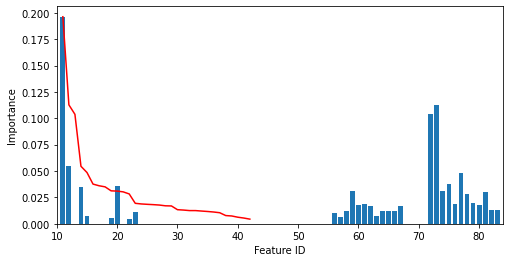

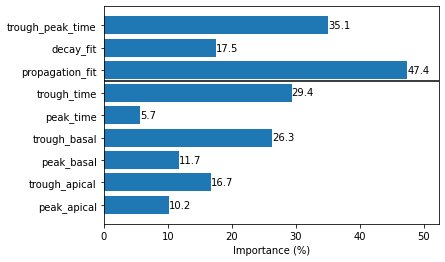

In [21]:
feat_labels_df = pd.DataFrame({'id': feat_ids, 'importance': model_sel.feature_importances_,
                        'feature': summ_stats_names[feat_ids]})
feat_labels_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

_, ax = plt.subplots(figsize=(8, 4))
ax = plot_feature_inmportance(feat_labels_df, ax=ax)

fig, ax = plt.subplots(figsize=(6, 4))
cat_importance, ax = plot_importance_in_categories(feat_labels_df, summ_stats_categories, n_parts, ax=ax)

if sel_grid_feat_id.size:
    _ = plot_grid_inmportance(feat_labels_df)
plt.show()

In [22]:
# cutoff_importance = 0.01
# n_top = sum(feat_labels_df['importance'] >= cutoff_importance)
n_top = None

with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_labels_df.iloc[:n_top])

,id,importance,feature
0,11,0.196,t_tr_max_idx_y
1,73,0.113,tr_l_t2
2,72,0.104,tr_l_t1
3,12,0.0545,t_tr_max_val
4,77,0.0486,pk_l_t2
5,75,0.0376,tr_r_t2
6,20,0.0361,t_pk_max_val
7,14,0.035,t_tr_min_idx_y
8,74,0.0312,tr_r_t1
9,59,0.031,tr_r_w1


### Save model

In [24]:
out_name = 'morph'
MODEL_PATH = save_rf_model(in_name + '-' + out_name, model_sel, feat_ids=feat_ids, label_list=select_label, overwrite=overwrite)
feat_labels_df.to_csv(os.path.join(MODEL_PATH, in_name + '-allmorph_importance.csv'))

## Train on individual output

In [24]:
model_label = []

for L_idx in label_idx:
    model_L = RandomForestRegressor(random_state=rand_seed)
    model_L.fit(summ_stats_train, labels_train[:, L_idx])
    model_label.append(model_L)

### Evaluate model

In [25]:
for model_L, L, L_idx in zip(model_label, select_label, label_idx):
    y = labels_test[:, L_idx]
    output = model_L.predict(summ_stats_test)
    rmse = mean_squared_error(y, output, squared=False)
    print(L)
    print(f'RMSE: {rmse: .4g}')
    print('R2 Score: {:.3f}'.format(r2_score(y, output)))

l_t
RMSE:  0.1479
R2 Score: 0.934
lr_pt
RMSE:  0.416
R2 Score: 0.488
r_t
RMSE:  0.1679
R2 Score: 0.912
rr_dt
RMSE:  0.4115
R2 Score: 0.514


### Feature importance

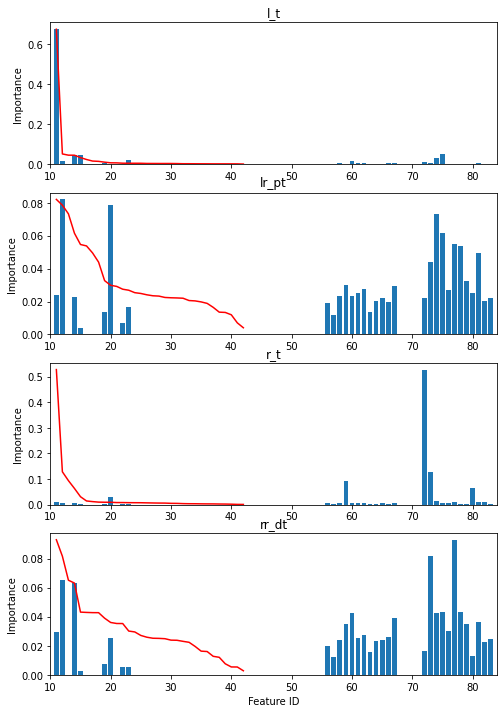

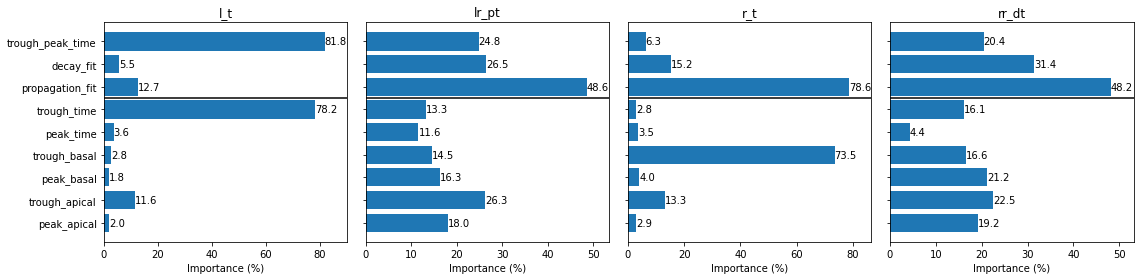

In [26]:
feat_label_df = {}
_, axs1 = plt.subplots(len(select_label), 1, figsize=(8, 3 * len(select_label)))
_, axs2 = plt.subplots(1, len(select_label), figsize=(4 * len(select_label), 4))
if sel_grid_feat_id.size:
    _, axs3 = plt.subplots(len(sel_mag_scale), len(select_label),
                           figsize=((4 * len(select_label), 3.5 * len(sel_mag_scale))), squeeze=False)
y_pos = np.arange(len(summ_stats_categories))

for i, (model_L, L) in enumerate(zip(model_label, select_label)):
    feat_L_df = pd.DataFrame({'id': feat_ids, 'importance': model_L.feature_importances_,
                              'feature': summ_stats_names[feat_ids]})
    feat_L_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)
    feat_label_df[L] = feat_L_df

    ax = plot_feature_inmportance(feat_L_df, ax=axs1[i], xlabel=False)
    ax.set_title(L)

    cat_importance, ax = plot_importance_in_categories(feat_L_df, summ_stats_categories, n_parts, ax=axs2[i], ylabel=not i)
    ax.set_title(L)

    if sel_grid_feat_id.size:
        grid_importance, _ = plot_grid_inmportance(feat_L_df, axs=axs3[:, i])
        ax = axs3[0, i]
        ax.set_title(('' if i else ax.get_title() + ', ') + L)
axs1[-1].set_xlabel('Feature ID')
plt.tight_layout()
plt.show()

In [27]:
feat_alllabel_df = pd.concat(feat_label_df, axis=1)
with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_alllabel_df)

l_t                            lr_pt                            r_t  \
    id importance         feature    id importance         feature  id   
0   11      0.675  t_tr_max_idx_y    12     0.0821    t_tr_max_val  72   
1   75     0.0517         tr_r_t2    20     0.0786    t_pk_max_val  73   
2   14     0.0456  t_tr_min_idx_y    74     0.0733         tr_r_t1  59   
3   15     0.0454    t_tr_min_val    75     0.0615         tr_r_t2  80   
4   74     0.0334         tr_r_t1    77     0.0547         pk_l_t2  20   
5   23     0.0239    t_pk_min_val    78     0.0538         pk_r_t1  74   
6   12     0.0161    t_tr_max_val    81     0.0496      tr_r_tprop  77   
7   60     0.0146         tr_r_w2    73      0.044         tr_l_t2  82   
8   72     0.0106         tr_l_t1    79     0.0327         pk_r_t2  11   
9   81    0.00736      tr_r_tprop    59     0.0299         tr_r_w1  81   
10  19    0.00706  t_pk_max_idx_y    67     0.0292         pk_r_y1  14   
11  61    0.00541         tr_r_y1    62     0.0275         pk_l_w1  67   
12  73     0.0052         tr_l_t2    76     0.0269         pk_l_t1  12   
13  66    0.00515         pk_r_w2    61     0.0254         tr_r_y1  65   
14  67    0.00509         pk_r_y1    80     0.0249      tr_l_tprop  56   
15  58    0.00416         tr_l_y1    11     0.0241  t_tr_max_idx_y  62   
16  62    0.00405         pk_l_w1    58     0.0235         tr_l_y1  58   
17  20    0.00394    t_pk_max_val    60     0.0233         tr_r_w2  76   
18  77    0.00394         pk_l_t2    14     0.0225  t_tr_min_idx_y  61   
19  59    0.00392         tr_r_w1    83     0.0223      pk_r_tprop  75   
20  56    0.00354         tr_l_w1    72     0.0222         tr_l_t1  60   
21  78    0.00283         pk_r_t1    65      0.022         pk_r_w1  79   
22  76    0.00282         pk_l_t1    64     0.0206         pk_l_y1  64   
23  63    0.00261         pk_l_w2    82     0.0204      pk_l_tprop  78   
24  80    0.00248      tr_l_tprop    66     0.0198         pk_r_w2  66   
25  83     0.0024      pk_r_tprop    56     0.0189         tr_l_w1  83   
26  64    0.00222         pk_l_y1    23     0.0165    t_pk_min_val  15   
27  79     0.0022         pk_r_t2    19     0.0136  t_pk_max_idx_y  23   
28  82    0.00219      pk_l_tprop    63     0.0134         pk_l_w2  63   
29  65    0.00219         pk_r_w1    57      0.012         tr_l_w2  57   
30  57    0.00211         tr_l_w2    22    0.00705  t_pk_min_idx_y  22   
31  22    0.00117  t_pk_min_idx_y    15    0.00407    t_tr_min_val  19   

                              rr_dt                             
   importance         feature    id importance         feature  
0       0.527         tr_l_t1    77     0.0931         pk_l_t2  
1       0.128         tr_l_t2    73     0.0817         tr_l_t2  
2      0.0937         tr_r_w1    12     0.0652    t_tr_max_val  
3      0.0632      tr_l_tprop    14     0.0632  t_tr_min_idx_y  
4      0.0309    t_pk_max_val    78     0.0432         pk_r_t1  
5      0.0143         tr_r_t1    75      0.043         tr_r_t2  
6      0.0118         pk_l_t2    60     0.0429         tr_r_w2  
7     0.00981      pk_l_tprop    74     0.0428         tr_r_t1  
8     0.00934  t_tr_max_idx_y    67      0.039         pk_r_y1  
9     0.00917      tr_r_tprop    81     0.0361      tr_r_tprop  
10    0.00813  t_tr_min_idx_y    59     0.0354         tr_r_w1  
11     0.0081         pk_r_y1    79     0.0353         pk_r_t2  
12     0.0077    t_tr_max_val    76     0.0302         pk_l_t1  
13    0.00754         pk_r_w1    11     0.0295  t_tr_max_idx_y  
14    0.00742         tr_l_w1    62     0.0271         pk_l_w1  
15    0.00692         pk_l_w1    66     0.0259         pk_r_w2  
16    0.00646         tr_l_y1    20     0.0252    t_pk_max_val  
17    0.00611         pk_l_t1    61     0.0251         tr_r_y1  
18    0.00599         tr_r_y1    83     0.0249      pk_r_tprop  
19    0.00506         tr_r_t2    58     0.0239         tr_l_y1  
20    0.00483         tr_r_w2    65     0.0238         p

### Save model

In [28]:
for model_L, L in zip(model_label, select_label):
    MODEL_PATH = save_rf_model(in_name + '-' + L, model_L, feat_ids=feat_ids, label_list=[L], overwrite=overwrite)
feat_alllabel_df.to_csv(os.path.join(MODEL_PATH, in_name + '-individual_importance.csv'))

## Troughs/peaks min/max time

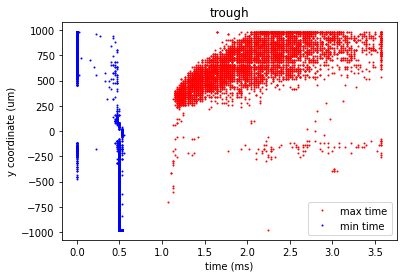

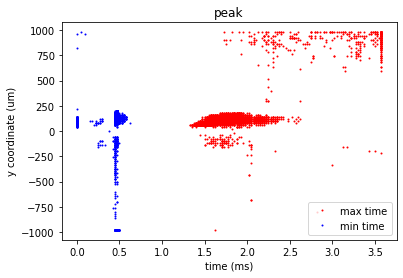

In [29]:
for m, fid in zip(['trough', 'peak'], tr_pk_time_id.reshape(2, -1)):
    y_max, y_min = [DY * full_summ_stats[:,  i] - params.Y_WINDOW_SIZE / 2 for i in fid[::2]]
    t_max, t_min = [params.DT * full_summ_stats[:,  i] for i in fid[1::2]]
    plt.figure(figsize=(6, 4))
    plt.plot(t_max, y_max, 'r.', markersize=2, label='max time')
    plt.plot(t_min, y_min, 'b.', markersize=2, label='min time')
    plt.xlabel('time (ms)')
    plt.ylabel('y coordinate (um)')
    plt.legend(loc='lower right')
    plt.title(m)
    plt.show()

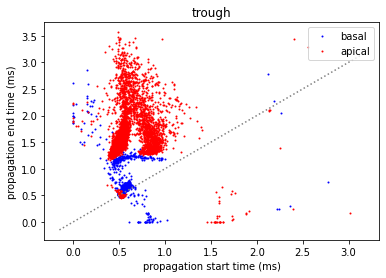

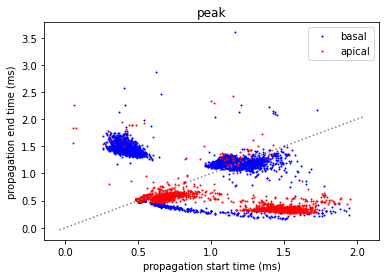

In [30]:
for m, fid in zip(['trough', 'peak'], [range(72, 76), range(76, 80)]):
    l_t1, l_t2, r_t1, r_t2 = [params.DT * full_summ_stats[:, i] for i in fid]
    plt.figure(figsize=(6, 4))
    plt.plot(l_t1, l_t2, 'b.', markersize=2, label='basal')
    plt.plot(r_t1, r_t2, 'r.', markersize=2, label='apical')
    xl = plt.gca().get_xlim()
    plt.plot(xl, xl, linestyle=':', color='grey')
    plt.xlabel('propagation start time (ms)')
    plt.ylabel('propagation end time (ms)')
    plt.legend(loc='upper right')
    plt.title(m)
    plt.show()